## SQL IPYNB

# This notebook is a SQL notebook that can be run in Jupyter Notebook or JupyterLab.
# It will be used to queury the columns for our project.

In [2]:
# Install required libraries (only once)
# !pip install wbdata pandas

import wbdata
import pandas as pd
import sqlite3

# 1. Set indicators
indicators = {
    'SP.DYN.LE00.IN': 'life_expectancy',
    'SH.DYN.MORT': 'under5_mortality_rate',
    'SP.ADO.TFRT': 'adolescent_fertility_rate'
}

# 2. Fetch data (NO date filter)
df = wbdata.get_dataframe(indicators)

# 3. Reset index
df = df.reset_index()

# 4. Drop rows with missing values
df = df.dropna()

# 5. Load into SQLite in-memory database
conn = sqlite3.connect(':memory:')
df.to_sql('population_data', conn, index=False, if_exists='replace')

# 6. Create cleaned table
conn.execute("""
CREATE TABLE cleaned_population_data AS
SELECT
    country,
    date,
    life_expectancy,
    under5_mortality_rate,
    adolescent_fertility_rate
FROM
    population_data
WHERE
    life_expectancy IS NOT NULL
    AND under5_mortality_rate IS NOT NULL
    AND adolescent_fertility_rate IS NOT NULL
""")
conn.commit()

# 7. Descriptive stats
stats_query = """
SELECT
    AVG(life_expectancy) AS avg_life_expectancy,
    MIN(life_expectancy) AS min_life_expectancy,
    MAX(life_expectancy) AS max_life_expectancy,
    AVG(under5_mortality_rate) AS avg_under5_mortality,
    MIN(under5_mortality_rate) AS min_under5_mortality,
    MAX(under5_mortality_rate) AS max_under5_mortality,
    AVG(adolescent_fertility_rate) AS avg_adolescent_fertility,
    MIN(adolescent_fertility_rate) AS min_adolescent_fertility,
    MAX(adolescent_fertility_rate) AS max_adolescent_fertility
FROM
    cleaned_population_data
"""
stats_result = pd.read_sql_query(stats_query, conn)
print(stats_result)

# 8. Group by country
grouped_query = """
SELECT
    country,
    AVG(life_expectancy) AS avg_life_expectancy,
    AVG(under5_mortality_rate) AS avg_under5_mortality_rate,
    AVG(adolescent_fertility_rate) AS avg_adolescent_fertility_rate
FROM
    cleaned_population_data
GROUP BY
    country
ORDER BY
    avg_life_expectancy DESC
"""
grouped_result = pd.read_sql_query(grouped_query, conn)
print(grouped_result.head())


# Query the cleaned table into a DataFrame
cleaned_df = pd.read_sql_query("SELECT * FROM cleaned_population_data", conn)

# Now cleaned_df is a normal DataFrame you can manipulate
print(cleaned_df.head())



   avg_life_expectancy  min_life_expectancy  max_life_expectancy  \
0            65.252508               10.989               86.372   

   avg_under5_mortality  min_under5_mortality  max_under5_mortality  \
0             71.114946                   1.4                 767.4   

   avg_adolescent_fertility  min_adolescent_fertility  \
0                 72.515224                     0.512   

   max_adolescent_fertility  
0                   229.604  
                     country  avg_life_expectancy  avg_under5_mortality_rate  \
0                     Monaco            82.924282                   5.166667   
1                    Andorra            82.030308                   7.423077   
2                 San Marino            81.448641                   6.107692   
3                  Euro area            79.545286                   5.312769   
4  Post-demographic dividend            78.542056                   6.698336   

   avg_adolescent_fertility_rate  
0                      14.336

In [3]:
# Convert 'date' to integer
cleaned_df['date'] = cleaned_df['date'].astype(int)

# Check
print(cleaned_df.dtypes)

country                       object
date                           int64
life_expectancy              float64
under5_mortality_rate        float64
adolescent_fertility_rate    float64
dtype: object


In [4]:
# Define the 7 major regions you want
regions_of_interest = [
    'East Asia & Pacific',
    'Europe & Central Asia',
    'Latin America & Caribbean',
    'Middle East & North Africa',
    'North America',
    'South Asia',
    'Sub-Saharan Africa'
]

# Filter cleaned_df
region_df = cleaned_df[cleaned_df['country'].isin(regions_of_interest)]

# Check what you get
print(region_df['country'].unique())
region_df.head()

['East Asia & Pacific' 'Europe & Central Asia' 'Latin America & Caribbean'
 'Middle East & North Africa' 'North America' 'South Asia'
 'Sub-Saharan Africa']


,country,date,life_expectancy,under5_mortality_rate,adolescent_fertility_rate
204,East Asia & Pacific,2023,76.659477,14.5,14.565804
205,East Asia & Pacific,2022,76.676784,14.7,14.800343
206,East Asia & Pacific,2021,76.153009,14.9,15.197225
207,East Asia & Pacific,2020,76.543438,14.9,15.878941
208,East Asia & Pacific,2019,76.586262,14.8,17.261394


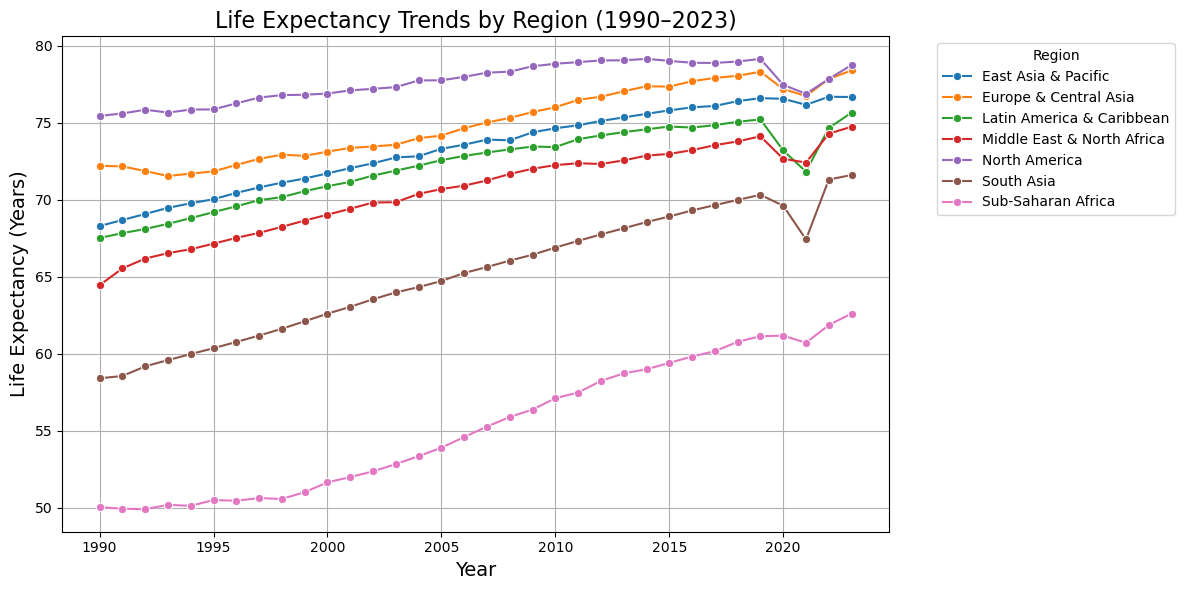

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Life Expectancy over Time for 7 regions
plt.figure(figsize=(12,6))
sns.lineplot(
    data=region_df,
    x='date',
    y='life_expectancy',
    hue='country',
    marker='o'
)

plt.title('Life Expectancy Trends by Region (1990–2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Life Expectancy (Years)', fontsize=14)
plt.grid(True)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

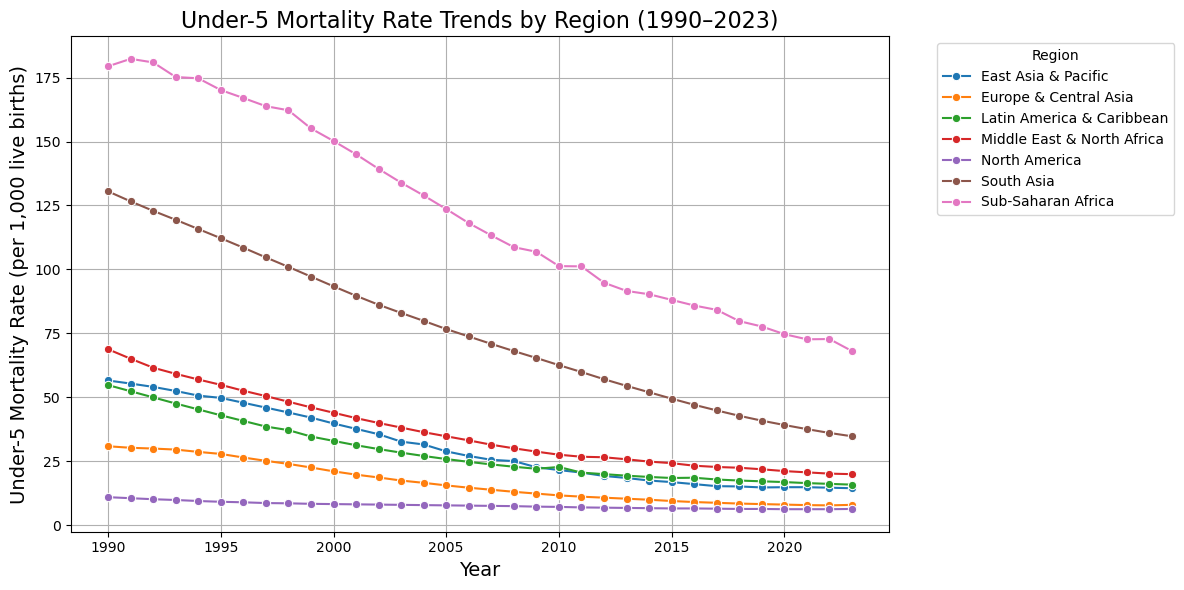

In [6]:
# Plot Under-5 Mortality over Time for 7 regions
plt.figure(figsize=(12,6))
sns.lineplot(
    data=region_df,
    x='date',
    y='under5_mortality_rate',
    hue='country',
    marker='o'
)

plt.title('Under-5 Mortality Rate Trends by Region (1990–2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Under-5 Mortality Rate (per 1,000 live births)', fontsize=14)
plt.grid(True)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

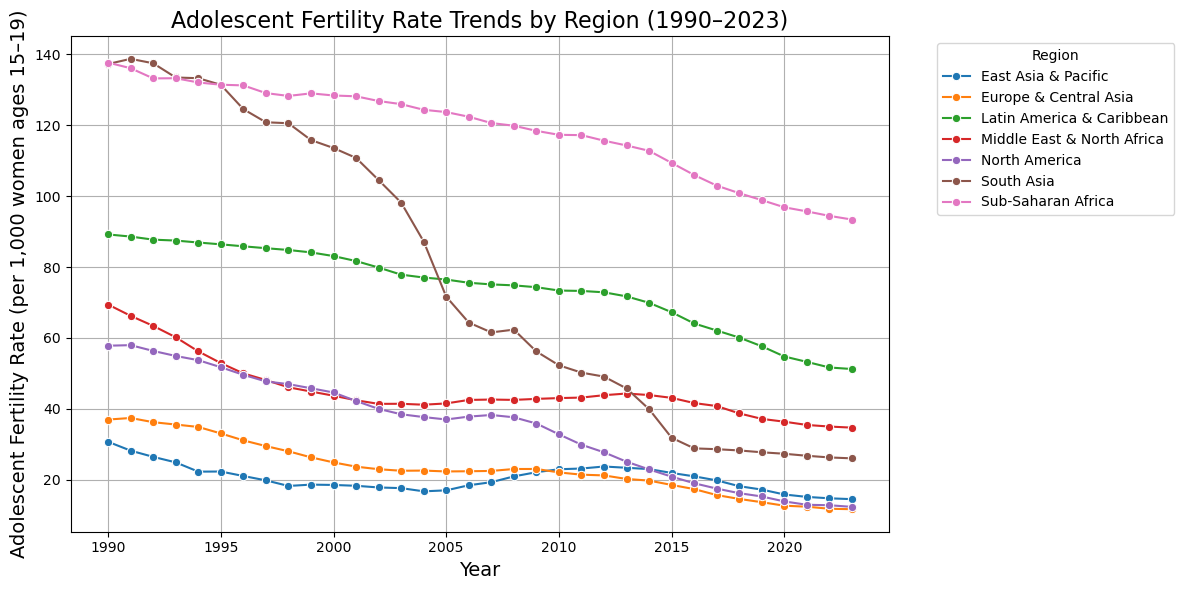

In [7]:
# Plot Adolescent Fertility over Time for 7 regions
plt.figure(figsize=(12,6))
sns.lineplot(
    data=region_df,
    x='date',
    y='adolescent_fertility_rate',
    hue='country',
    marker='o'
)

plt.title('Adolescent Fertility Rate Trends by Region (1990–2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Adolescent Fertility Rate (per 1,000 women ages 15–19)', fontsize=14)
plt.grid(True)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()